<a href="https://colab.research.google.com/github/KlamJ/DeepLab_V3_KL/blob/master/Klamer_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Bild](https://drive.google.com/uc?id=18KhcCqqeHGeL3Fmsliv2gV2vBcFIy2cP)

# Cityscapes Dataset


Der Cityscapes Datensatz konzentriert sich auf die semantische Segmentierung von städtischen Straßenszenen. Im Folgenden wird mithilfe dieses Datensatzes das DCNN DeepLabV3 Trainiert und evaluiert.


##TO DO 
 
 - Beschreibung der AUfgabe und Motivation
 - Beschreibung des DeepLab
 - Beschreibung der Datensatzes 
 - Beschreibung der einzelen Codeblöcke 
  - https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
  - beschreiben warum adam !!!
 - Code Blöcke entzerren und verkleinern
 - modele Trainieren mit verschiedenen Volumen 
  - mit verschiedenen Netzten ? (Zeit) 
 - Präsentation Anlegen vor Weihnachten fertig machen 
 - Präsentation warsch. am 15.01.20
 
 **NOTIZEN : **
Resnet18

model 2: 
  - batch 3 
  - worker 4

model 3: 
  - batch 30
  - worker 4

model 5
 - batch 3
 - worker 2 





##Präsentation

- 15min 
- 15 slides max 
- einführung hälfte technik deeplab 
- ergebnisse andere hälfte 






Training mehr als eine instanz lang 
https://medium.com/@prajwal.prashanth22/google-colab-drive-as-persistent-storage-for-long-training-runs-cb82bc1d5b71


###Mount GoogleDrive 


In [7]:
## Mount Drive
from google.colab import drive
drive.mount('/content/drive')

#https://github.com/KlamJ/deeplabv3
#https://drive.google.com/open?id=17mKymLGO6mQxSnbHLsg7TwzGgoQK1MpN

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###Check Gpu status

In [11]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [12]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=90839127cead42cc6f1da5182ffbfc80e1afc746654b724f70a82f64b82223dd
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 24.7 GB  | Proc size: 2.8 GB
GPU RAM Free: 15567MB | Used: 713MB | Util   4% | Total 16280MB


In [0]:
#if not the only user and the gpu Util is >0 do following 
!kill -9 -1

#DeepLab

##The DeepLab V3 


Importieren der Benötigten Bibliotheken

In [0]:
%matplotlib inline
import sys
import cv2
datasetPath = "/content/drive/My Drive/U_Net_Datasets"
cityscapes_data_path="/content/drive/My Drive/U_Net_Datasets"
cityscapes_meta_path="/content/drive/My Drive/U_Net_Datasets/meta"



####Utils

In [0]:
import numpy as np

import os
import pickle
from collections import namedtuple
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.autograd import Variable
import torch.optim as optim
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import time


train_dirs = ["jena/", "zurich/", "weimar/", "ulm/", "tubingen/", "stuttgart/",
              "strasbourg/", "monchengladbach/", "krefeld/", "hanover/",
             "hamburg/", "erfurt/", "dusseldorf/", "darmstadt/", "cologne/",
             "bremen/", "bochum/", "aachen/"]
val_dirs = ["frankfurt/", "munster/", "lindau/"]
test_dirs = ["berlin", "bielefeld", "bonn", "leverkusen", "mainz", "munich"]

class DatasetTrain(torch.utils.data.Dataset):
    def __init__(self, cityscapes_data_path, cityscapes_meta_path):
        self.img_dir = cityscapes_data_path + "/leftImg8bit/train/"
        self.label_dir = cityscapes_meta_path + "/label_imgs/"

        self.img_h = 1024
        self.img_w = 2048

        self.new_img_h = 512
        self.new_img_w = 1024

        self.examples = []
        for train_dir in train_dirs:
            train_img_dir_path = self.img_dir + train_dir

            file_names = os.listdir(train_img_dir_path)
            for file_name in file_names:
                img_id = file_name.split("_leftImg8bit.png")[0]

                img_path = train_img_dir_path + file_name

                label_img_path = self.label_dir + img_id + ".png"

                example = {}
                example["img_path"] = img_path
                example["label_img_path"] = label_img_path
                example["img_id"] = img_id
                self.examples.append(example)

        self.num_examples = len(self.examples)

    def __getitem__(self, index):
        example = self.examples[index]

        img_path = example["img_path"]
        img = cv2.imread(img_path, -1) # (shape: (1024, 2048, 3))
        # resize img without interpolation (want the image to still match
        # label_img, which we resize below):
        img = cv2.resize(img, (self.new_img_w, self.new_img_h),
                         interpolation=cv2.INTER_NEAREST) # (shape: (512, 1024, 3))

        label_img_path = example["label_img_path"]
        label_img = cv2.imread(label_img_path, -1) # (shape: (1024, 2048))
        # resize label_img without interpolation (want the resulting image to
        # still only contain pixel values corresponding to an object class):
        label_img = cv2.resize(label_img, (self.new_img_w, self.new_img_h),
                               interpolation=cv2.INTER_NEAREST) # (shape: (512, 1024))

        # flip the img and the label with 0.5 probability:
        flip = np.random.randint(low=0, high=2)
        if flip == 1:
            img = cv2.flip(img, 1)
            label_img = cv2.flip(label_img, 1)

        ########################################################################
        # randomly scale the img and the label:
        ########################################################################
        scale = np.random.uniform(low=0.7, high=2.0)
        new_img_h = int(scale*self.new_img_h)
        new_img_w = int(scale*self.new_img_w)

        # resize img without interpolation (want the image to still match
        # label_img, which we resize below):
        img = cv2.resize(img, (new_img_w, new_img_h),
                         interpolation=cv2.INTER_NEAREST) # (shape: (new_img_h, new_img_w, 3))

        # resize label_img without interpolation (want the resulting image to
        # still only contain pixel values corresponding to an object class):
        label_img = cv2.resize(label_img, (new_img_w, new_img_h),
                               interpolation=cv2.INTER_NEAREST) # (shape: (new_img_h, new_img_w))
        ########################################################################

         # # # # # # # debug visualization START
        #print (scale)
        #print (new_img_h)
        #print (new_img_w)
        
        #cv2.imshow("test", img)
        #cv2.waitKey(0)
        
        #cv2.imshow("test", label_img)
        #cv2.waitKey(0)
         # # # # # # # debug visualization END

        ########################################################################
        # select a 256x256 random crop from the img and label:
        ########################################################################
        start_x = np.random.randint(low=0, high=(new_img_w - 256))
        end_x = start_x + 256
        start_y = np.random.randint(low=0, high=(new_img_h - 256))
        end_y = start_y + 256

        img = img[start_y:end_y, start_x:end_x] # (shape: (256, 256, 3))
        label_img = label_img[start_y:end_y, start_x:end_x] # (shape: (256, 256))
        ########################################################################

        # # # # # # # # debug visualization START
        # print (img.shape)
        # print (label_img.shape)
        #
        # cv2.imshow("test", img)
        # cv2.waitKey(0)
        #
        # cv2.imshow("test", label_img)
        # cv2.waitKey(0)
        # # # # # # # # debug visualization END

        # normalize the img (with the mean and std for the pretrained ResNet):
        img = img/255.0
        img = img - np.array([0.485, 0.456, 0.406])
        img = img/np.array([0.229, 0.224, 0.225]) # (shape: (256, 256, 3))
        img = np.transpose(img, (2, 0, 1)) # (shape: (3, 256, 256))
        img = img.astype(np.float32)

        # convert numpy -> torch:
        img = torch.from_numpy(img) # (shape: (3, 256, 256))
        label_img = torch.from_numpy(label_img) # (shape: (256, 256))

        return (img, label_img)

    def __len__(self):
        return self.num_examples

class DatasetVal(torch.utils.data.Dataset):
    def __init__(self, cityscapes_data_path, cityscapes_meta_path):
        self.img_dir = cityscapes_data_path + "/leftImg8bit/val/"
        self.label_dir = cityscapes_meta_path + "/label_imgs/"

        self.img_h = 1024
        self.img_w = 2048

        self.new_img_h = 512
        self.new_img_w = 1024

        self.examples = []
        for val_dir in val_dirs:
            val_img_dir_path = self.img_dir + val_dir

            file_names = os.listdir(val_img_dir_path)
            for file_name in file_names:
                img_id = file_name.split("_leftImg8bit.png")[0]

                img_path = val_img_dir_path + file_name

                label_img_path = self.label_dir + img_id + ".png"
                label_img = cv2.imread(label_img_path, -1) # (shape: (1024, 2048))

                example = {}
                example["img_path"] = img_path
                example["label_img_path"] = label_img_path
                example["img_id"] = img_id
                self.examples.append(example)

        self.num_examples = len(self.examples)

    def __getitem__(self, index):
        example = self.examples[index]

        img_id = example["img_id"]

        img_path = example["img_path"]
        img = cv2.imread(img_path, -1) # (shape: (1024, 2048, 3))
        # resize img without interpolation (want the image to still match
        # label_img, which we resize below):
        img = cv2.resize(img, (self.new_img_w, self.new_img_h),
                         interpolation=cv2.INTER_NEAREST) # (shape: (512, 1024, 3))

        label_img_path = example["label_img_path"]
        label_img = cv2.imread(label_img_path, -1) # (shape: (1024, 2048))
        # resize label_img without interpolation (want the resulting image to
        # still only contain pixel values corresponding to an object class):
        label_img = cv2.resize(label_img, (self.new_img_w, self.new_img_h),
                               interpolation=cv2.INTER_NEAREST) # (shape: (512, 1024))

        # # # # # # # # debug visualization START
        # cv2.imshow("test", img)
        # cv2.waitKey(0)
        #
        # cv2.imshow("test", label_img)
        # cv2.waitKey(0)
        # # # # # # # # debug visualization END

        # normalize the img (with the mean and std for the pretrained ResNet):
        img = img/255.0
        img = img - np.array([0.485, 0.456, 0.406])
        img = img/np.array([0.229, 0.224, 0.225]) # (shape: (512, 1024, 3))
        img = np.transpose(img, (2, 0, 1)) # (shape: (3, 512, 1024))
        img = img.astype(np.float32)

        # convert numpy -> torch:
        img = torch.from_numpy(img) # (shape: (3, 512, 1024))
        label_img = torch.from_numpy(label_img) # (shape: (512, 1024))

        return (img, label_img, img_id)

    def __len__(self):
        return self.num_examples

class DatasetSeq(torch.utils.data.Dataset):
    def __init__(self, cityscapes_data_path, cityscapes_meta_path, sequence):
        self.img_dir = cityscapes_data_path + "/leftImg8bit/demoVideo/stuttgart_" + sequence + "/"

        self.img_h = 1024
        self.img_w = 2048

        self.new_img_h = 512
        self.new_img_w = 1024

        self.examples = []

        file_names = os.listdir(self.img_dir)
        for file_name in file_names:
            img_id = file_name.split("_leftImg8bit.png")[0]

            img_path = self.img_dir + file_name

            example = {}
            example["img_path"] = img_path
            example["img_id"] = img_id
            self.examples.append(example)

        self.num_examples = len(self.examples)

    def __getitem__(self, index):
        example = self.examples[index]

        img_id = example["img_id"]

        img_path = example["img_path"]
        img = cv2.imread(img_path, -1) # (shape: (1024, 2048, 3))
        # resize img without interpolation:
        img = cv2.resize(img, (self.new_img_w, self.new_img_h),
                         interpolation=cv2.INTER_NEAREST) # (shape: (512, 1024, 3))

        # normalize the img (with the mean and std for the pretrained ResNet):
        img = img/255.0
        img = img - np.array([0.485, 0.456, 0.406])
        img = img/np.array([0.229, 0.224, 0.225]) # (shape: (512, 1024, 3))
        img = np.transpose(img, (2, 0, 1)) # (shape: (3, 512, 1024))
        img = img.astype(np.float32)

        # convert numpy -> torch:
        img = torch.from_numpy(img) # (shape: (3, 512, 1024))

        return (img, img_id)

    def __len__(self):
        return self.num_examples

class DatasetThnSeq(torch.utils.data.Dataset):
    def __init__(self, thn_data_path):
        self.img_dir = thn_data_path + "/"

        self.examples = []

        file_names = os.listdir(self.img_dir)
        for file_name in file_names:
            img_id = file_name.split(".png")[0]

            img_path = self.img_dir + file_name

            example = {}
            example["img_path"] = img_path
            example["img_id"] = img_id
            self.examples.append(example)

        self.num_examples = len(self.examples)

    def __getitem__(self, index):
        example = self.examples[index]

        img_id = example["img_id"]

        img_path = example["img_path"]
        img = cv2.imread(img_path, -1) # (shape: (512, 1024, 3))

        # normalize the img (with mean and std for the pretrained ResNet):
        img = img/255.0
        img = img - np.array([0.485, 0.456, 0.406])
        img = img/np.array([0.229, 0.224, 0.225]) # (shape: (512, 1024, 3))
        img = np.transpose(img, (2, 0, 1)) # (shape: (3, 512, 1024))
        img = img.astype(np.float32)

        # convert numpy -> torch:
        img = torch.from_numpy(img) # (shape: (3, 512, 1024))

        return (img, img_id)

    def __len__(self):
        return self.num_examples



In [0]:


def add_weight_decay(net, l2_value, skip_list=()):
    # https://raberrytv.wordpress.com/2017/10/29/pytorch-weight-decay-made-easy/

    decay, no_decay = [], []
    for name, param in net.named_parameters():
        if not param.requires_grad:
            continue # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)

    return [{'params': no_decay, 'weight_decay': 0.0}, {'params': decay, 'weight_decay': l2_value}]

# function for colorizing a label image:
def label_img_to_color(img):
    label_to_color = {
        0: [128, 64,128],
        1: [244, 35,232],
        2: [ 70, 70, 70],
        3: [102,102,156],
        4: [190,153,153],
        5: [153,153,153],
        6: [250,170, 30],
        7: [220,220,  0],
        8: [107,142, 35],
        9: [152,251,152],
        10: [ 70,130,180],
        11: [220, 20, 60],
        12: [255,  0,  0],
        13: [  0,  0,142],
        14: [  0,  0, 70],
        15: [  0, 60,100],
        16: [  0, 80,100],
        17: [  0,  0,230],
        18: [119, 11, 32],
        19: [81,  0, 81]
        }

    img_height, img_width = img.shape

    img_color = np.zeros((img_height, img_width, 3))
    for row in range(img_height):
        for col in range(img_width):
            label = img[row, col]

            img_color[row, col] = np.array(label_to_color[label])

    return img_color

###Preprocessing

#### Einmalige ausführung zum erzeugen der Label und Klassengewichte


In [0]:


# (NOTE! this is taken from the official Cityscapes scripts:)
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

# (NOTE! this is taken from the official Cityscapes scripts:)
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      19 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      19 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      19 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      19 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      19 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      19 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      19 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      19 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      19 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      19 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

# create a function which maps id to trainId:
id_to_trainId = {label.id: label.trainId for label in labels}
id_to_trainId_map_func = np.vectorize(id_to_trainId.get)

train_dirs = ["jena/", "zurich/", "weimar/", "ulm/", "tubingen/", "stuttgart/",
              "strasbourg/", "monchengladbach/", "krefeld/", "hanover/",
              "hamburg/", "erfurt/", "dusseldorf/", "darmstadt/", "cologne/",
              "bremen/", "bochum/", "aachen/"]
val_dirs = ["frankfurt/", "munster/", "lindau/"]
test_dirs = ["berlin", "bielefeld", "bonn", "leverkusen", "mainz", "munich"]

#cityscapes_data_path = "/root/deeplabv3/data/cityscapes"
#cityscapes_meta_path = "/root/deeplabv3/data/cityscapes/meta"

cityscapes_data_path = "/content/drive/My Drive/U_Net_Datasets"
cityscapes_meta_path = "/content/drive/My Drive/U_Net_Datasets/meta"

if not os.path.exists(cityscapes_meta_path):
    os.makedirs(cityscapes_meta_path)
if not os.path.exists(cityscapes_meta_path + "/label_imgs"):
    os.makedirs(cityscapes_meta_path + "/label_imgs")

################################################################################
# convert all labels to label imgs with trainId pixel values (and save to disk):
################################################################################
train_label_img_paths = []

img_dir = cityscapes_data_path + "/leftImg8bit/train/"
label_dir = cityscapes_data_path + "/gtFine/train/"
for train_dir in train_dirs:
    print (train_dir)

    train_img_dir_path = img_dir + train_dir
    train_label_dir_path = label_dir + train_dir

    file_names = os.listdir(train_img_dir_path)
    for file_name in file_names:
        img_id = file_name.split("_leftImg8bit.png")[0]

        gtFine_img_path = train_label_dir_path + img_id + "_gtFine_labelIds.png"
        gtFine_img = cv2.imread(gtFine_img_path, -1) # (shape: (1024, 2048))

        # convert gtFine_img from id to trainId pixel values:
        label_img = id_to_trainId_map_func(gtFine_img)#(shape: (1024, 2048))
        label_img = label_img.astype(np.uint8)

        cv2.imwrite(cityscapes_meta_path + "/label_imgs/" + img_id + ".png", label_img)
        train_label_img_paths.append(cityscapes_meta_path + "/label_imgs/" + img_id + ".png")

img_dir = cityscapes_data_path + "/leftImg8bit/val/"
label_dir = cityscapes_data_path + "/gtFine/val/"
for val_dir in val_dirs:
    print (val_dir)

    val_img_dir_path = img_dir + val_dir
    val_label_dir_path = label_dir + val_dir

    file_names = os.listdir(val_img_dir_path)
    for file_name in file_names:
        img_id = file_name.split("_leftImg8bit.png")[0]

        gtFine_img_path = val_label_dir_path + img_id + "_gtFine_labelIds.png"
        gtFine_img = cv2.imread(gtFine_img_path, -1) # (shape: (1024, 2048))

        # convert gtFine_img from id to trainId pixel values:
        label_img = id_to_trainId_map_func(gtFine_img) # (shape: (1024, 2048))
        label_img = label_img.astype(np.uint8)

        cv2.imwrite(cityscapes_meta_path + "/label_imgs/" + img_id + ".png", label_img)

################################################################################
# compute the class weigths:
################################################################################
print ("computing class weights")

num_classes = 20

trainId_to_count = {}
for trainId in range(num_classes):
    trainId_to_count[trainId] = 0

# get the total number of pixels in all train label_imgs that are of each object class:
for step, label_img_path in enumerate(train_label_img_paths):
    if step % 100 == 0:
        print (step)

    label_img = cv2.imread(label_img_path, -1)

    for trainId in range(num_classes):
        # count how many pixels in label_img which are of object class trainId:
        trainId_mask = np.equal(label_img, trainId)
        trainId_count = np.sum(trainId_mask)

        # add to the total count:
        trainId_to_count[trainId] += trainId_count

# compute the class weights according to the ENet paper:
class_weights = []
total_count = sum(trainId_to_count.values())
for trainId, count in trainId_to_count.items():
    trainId_prob = float(count)/float(total_count)
    trainId_weight = 1/np.log(1.02 + trainId_prob)
    class_weights.append(trainId_weight)

print (class_weights)

with open(cityscapes_meta_path + "/class_weights.pkl", "wb") as file:
    pickle.dump(class_weights, file, protocol=2) # (protocol=2 is needed to be able to open this file with python2)

jena/
zurich/
weimar/
ulm/
tubingen/
stuttgart/
strasbourg/
monchengladbach/
krefeld/
hanover/
hamburg/
erfurt/
dusseldorf/
darmstadt/
cologne/
bremen/
bochum/
aachen/
frankfurt/
munster/
lindau/
computing class weights
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
[3.362088928135997, 14.031521298730318, 4.986657918172686, 39.254403222891234, 36.5125971773311, 32.89620795239199, 46.286660134462245, 40.69042748040039, 6.698241903441155, 33.55545414377673, 18.487832644189325, 32.97431249303082, 47.676506488107115, 12.70028597336979, 45.20542136324199, 45.78372411642551, 45.825290445040096, 48.40614734589367, 42.75592219573717, 7.912219457368151]


In [0]:
#einmalige ausführung
#import zipfile
#path_to_zip_file = #'/content/drive/My Drive/U_Net_Datasets/gtFine_trainvaltest.zip'
#directory_to_extract_to = '/content/drive/My Drive/U_Net_Datasets' 
#with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#    zip_ref.extractall(directory_to_extract_to)

####Random Code

In [0]:
# this file contains code snippets which I have found (more or less) useful at
# some point during the project. Probably nothing interesting to see here.

import pickle
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

import numpy as np

model_id = "13_2_2_2"

with open("/home/fregu856/exjobb/training_logs/multitask/model_" + model_id + "/epoch_losses_train.pkl", "rb") as file:
    train_loss = pickle.load(file)

with open("/home/fregu856/exjobb/training_logs/multitask/model_" + model_id + "/epoch_losses_val.pkl", "rb") as file:
    val_loss = pickle.load(file)

print ("train loss min:", np.argmin(np.array(train_loss)), np.min(np.array(train_loss)))

print ("val loss min:", np.argmin(np.array(val_loss)), np.min(np.array(val_loss)))

###Model

####ASPP

In [0]:


class ASPP(nn.Module):
    def __init__(self, num_classes):
        super(ASPP, self).__init__()

        self.conv_1x1_1 = nn.Conv2d(512, 256, kernel_size=1)
        self.bn_conv_1x1_1 = nn.BatchNorm2d(256)

        self.conv_3x3_1 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn_conv_3x3_1 = nn.BatchNorm2d(256)

        self.conv_3x3_2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn_conv_3x3_2 = nn.BatchNorm2d(256)

        self.conv_3x3_3 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn_conv_3x3_3 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_1x1_2 = nn.Conv2d(512, 256, kernel_size=1)
        self.bn_conv_1x1_2 = nn.BatchNorm2d(256)

        self.conv_1x1_3 = nn.Conv2d(1280, 256, kernel_size=1) # (1280 = 5*256)
        self.bn_conv_1x1_3 = nn.BatchNorm2d(256)

        self.conv_1x1_4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, feature_map):
        # (feature_map has shape (batch_size, 512, h/16, w/16)) (assuming self.resnet is ResNet18_OS16 or ResNet34_OS16. If self.resnet instead is ResNet18_OS8 or ResNet34_OS8, it will be (batch_size, 512, h/8, w/8))

        feature_map_h = feature_map.size()[2] # (== h/16)
        feature_map_w = feature_map.size()[3] # (== w/16)

        out_1x1 = F.relu(self.bn_conv_1x1_1(self.conv_1x1_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_1 = F.relu(self.bn_conv_3x3_1(self.conv_3x3_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_2 = F.relu(self.bn_conv_3x3_2(self.conv_3x3_2(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_3 = F.relu(self.bn_conv_3x3_3(self.conv_3x3_3(feature_map))) # (shape: (batch_size, 256, h/16, w/16))

        out_img = self.avg_pool(feature_map) # (shape: (batch_size, 512, 1, 1))
        out_img = F.relu(self.bn_conv_1x1_2(self.conv_1x1_2(out_img))) # (shape: (batch_size, 256, 1, 1))
        out_img = F.upsample(out_img, size=(feature_map_h, feature_map_w), mode="bilinear") # (shape: (batch_size, 256, h/16, w/16))

        out = torch.cat([out_1x1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1) # (shape: (batch_size, 1280, h/16, w/16))
        out = F.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out))) # (shape: (batch_size, 256, h/16, w/16))
        out = self.conv_1x1_4(out) # (shape: (batch_size, num_classes, h/16, w/16))

        return out

class ASPP_Bottleneck(nn.Module):
    def __init__(self, num_classes):
        super(ASPP_Bottleneck, self).__init__()

        self.conv_1x1_1 = nn.Conv2d(4*512, 256, kernel_size=1)
        self.bn_conv_1x1_1 = nn.BatchNorm2d(256)

        self.conv_3x3_1 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn_conv_3x3_1 = nn.BatchNorm2d(256)

        self.conv_3x3_2 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn_conv_3x3_2 = nn.BatchNorm2d(256)

        self.conv_3x3_3 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn_conv_3x3_3 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_1x1_2 = nn.Conv2d(4*512, 256, kernel_size=1)
        self.bn_conv_1x1_2 = nn.BatchNorm2d(256)

        self.conv_1x1_3 = nn.Conv2d(1280, 256, kernel_size=1) # (1280 = 5*256)
        self.bn_conv_1x1_3 = nn.BatchNorm2d(256)

        self.conv_1x1_4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, feature_map):
        # (feature_map has shape (batch_size, 4*512, h/16, w/16))

        feature_map_h = feature_map.size()[2] # (== h/16)
        feature_map_w = feature_map.size()[3] # (== w/16)

        out_1x1 = F.relu(self.bn_conv_1x1_1(self.conv_1x1_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_1 = F.relu(self.bn_conv_3x3_1(self.conv_3x3_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_2 = F.relu(self.bn_conv_3x3_2(self.conv_3x3_2(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_3 = F.relu(self.bn_conv_3x3_3(self.conv_3x3_3(feature_map))) # (shape: (batch_size, 256, h/16, w/16))

        out_img = self.avg_pool(feature_map) # (shape: (batch_size, 512, 1, 1))
        out_img = F.relu(self.bn_conv_1x1_2(self.conv_1x1_2(out_img))) # (shape: (batch_size, 256, 1, 1))
        out_img = F.upsample(out_img, size=(feature_map_h, feature_map_w), mode="bilinear") # (shape: (batch_size, 256, h/16, w/16))

        out = torch.cat([out_1x1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1) # (shape: (batch_size, 1280, h/16, w/16))
        out = F.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out))) # (shape: (batch_size, 256, h/16, w/16))
        out = self.conv_1x1_4(out) # (shape: (batch_size, num_classes, h/16, w/16))

        return out

####ResNet

Verschiedene vortrainierte ResNet modelle zum Trainieren
Modellle sind auf ImageNet Datenbank vortrainiert

In [0]:
# NOTE! OS: output stride, the ratio of input image resolution to final output resolution (OS16: output size is (img_h/16, img_w/16)) (OS8: output size is (img_h/8, img_w/8))

preTrainedModelsPath = datasetPath + "/pretrained_models"

def make_layer(block, in_channels, channels, num_blocks, stride=1, dilation=1):
    strides = [stride] + [1]*(num_blocks - 1) # (stride == 2, num_blocks == 4 --> strides == [2, 1, 1, 1])

    blocks = []
    for stride in strides:
        blocks.append(block(in_channels=in_channels, channels=channels, stride=stride, dilation=dilation))
        in_channels = block.expansion*channels

    layer = nn.Sequential(*blocks) # (*blocks: call with unpacked list entires as arguments)

    return layer

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, channels, stride=1, dilation=1):
        super(BasicBlock, self).__init__()

        out_channels = self.expansion*channels

        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        if (stride != 1) or (in_channels != out_channels):
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            self.downsample = nn.Sequential(conv, bn)
        else:
            self.downsample = nn.Sequential()

    def forward(self, x):
        # (x has shape: (batch_size, in_channels, h, w))

        out = F.relu(self.bn1(self.conv1(x))) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)
        out = self.bn2(self.conv2(out)) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)

        out = out + self.downsample(x) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)

        out = F.relu(out) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, channels, stride=1, dilation=1):
        super(Bottleneck, self).__init__()

        out_channels = self.expansion*channels

        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        self.conv3 = nn.Conv2d(channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        if (stride != 1) or (in_channels != out_channels):
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            self.downsample = nn.Sequential(conv, bn)
        else:
            self.downsample = nn.Sequential()

    def forward(self, x):
        # (x has shape: (batch_size, in_channels, h, w))

        out = F.relu(self.bn1(self.conv1(x))) # (shape: (batch_size, channels, h, w))
        out = F.relu(self.bn2(self.conv2(out))) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)
        out = self.bn3(self.conv3(out)) # (shape: (batch_size, out_channels, h, w) if stride == 1, (batch_size, out_channels, h/2, w/2) if stride == 2)

        out = out + self.downsample(x) # (shape: (batch_size, out_channels, h, w) if stride == 1, (batch_size, out_channels, h/2, w/2) if stride == 2)

        out = F.relu(out) # (shape: (batch_size, out_channels, h, w) if stride == 1, (batch_size, out_channels, h/2, w/2) if stride == 2)

        return out

class ResNet_Bottleneck_OS16(nn.Module):
    def __init__(self, num_layers):
        super(ResNet_Bottleneck_OS16, self).__init__()

        if num_layers == 50:
            resnet = models.resnet50()
            # load pretrained model:
            resnet.load_state_dict(torch.load(preTrainedModelsPath+"/resnet/resnet50-19c8e357.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            print ("pretrained resnet, 50")
        elif num_layers == 101:
            resnet = models.resnet101()
            # load pretrained model:
            resnet.load_state_dict(torch.load(preTrainedModelsPath+"/resnet/resnet101-5d3b4d8f.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            print ("pretrained resnet, 101")
        elif num_layers == 152:
            resnet = models.resnet152()
            # load pretrained model:
            resnet.load_state_dict(torch.load(preTrainedModelsPath+"/resnet/resnet152-b121ed2d.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            print ("pretrained resnet, 152")
        else:
            raise Exception("num_layers must be in {50, 101, 152}!")

        self.layer5 = make_layer(Bottleneck, in_channels=4*256, channels=512, num_blocks=3, stride=1, dilation=2)

    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        # pass x through (parts of) the pretrained ResNet:
        c4 = self.resnet(x) # (shape: (batch_size, 4*256, h/16, w/16)) (it's called c4 since 16 == 2^4)

        output = self.layer5(c4) # (shape: (batch_size, 4*512, h/16, w/16))

        return output

class ResNet_BasicBlock_OS16(nn.Module):
    def __init__(self, num_layers):
        super(ResNet_BasicBlock_OS16, self).__init__()

        if num_layers == 18:
            resnet = models.resnet18()
            # load pretrained model:
            
            
            resnet.load_state_dict(torch.load(preTrainedModelsPath+"/resnet/resnet18-5c106cde.pth"))
            # remove fully connected layer, avg pool and layer5:
            
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            num_blocks = 2
            print ("pretrained resnet, 18")
        elif num_layers == 34:
            resnet = models.resnet34()
            # load pretrained model:
            resnet.load_state_dict(torch.load(preTrainedModelsPath+"/resnet/resnet34-333f7ec4.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            num_blocks = 3
            print ("pretrained resnet, 34")
        else:
            raise Exception("num_layers must be in {18, 34}!")

        self.layer5 = make_layer(BasicBlock, in_channels=256, channels=512, num_blocks=num_blocks, stride=1, dilation=2)

    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        # pass x through (parts of) the pretrained ResNet:
        c4 = self.resnet(x) # (shape: (batch_size, 256, h/16, w/16)) (it's called c4 since 16 == 2^4)

        output = self.layer5(c4) # (shape: (batch_size, 512, h/16, w/16))

        return output

class ResNet_BasicBlock_OS8(nn.Module):
    def __init__(self, num_layers):
        super(ResNet_BasicBlock_OS8, self).__init__()

        if num_layers == 18:
            resnet = models.resnet18()
            # load pretrained model:            
            resnet.load_state_dict(torch.load(preTrainedModelsPath+"/resnet/resnet18-5c106cde.pth"))       

            # remove fully connected layer, avg pool, layer4 and layer5:

            
            self.resnet = nn.Sequential(*list(resnet.children())[:-4])

            num_blocks_layer_4 = 2
            num_blocks_layer_5 = 2
            print ("pretrained resnet, 18")
        elif num_layers == 34:
            resnet = models.resnet34()
            # load pretrained model:
            resnet.load_state_dict(torch.load(preTrainedModelsPath+"/resnet/resnet34-333f7ec4.pth"))
            # remove fully connected layer, avg pool, layer4 and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-4])

            num_blocks_layer_4 = 6
            num_blocks_layer_5 = 3
            print ("pretrained resnet, 34")
        else:
            raise Exception("num_layers must be in {18, 34}!")

        self.layer4 = make_layer(BasicBlock, in_channels=128, channels=256, num_blocks=num_blocks_layer_4, stride=1, dilation=2)

        self.layer5 = make_layer(BasicBlock, in_channels=256, channels=512, num_blocks=num_blocks_layer_5, stride=1, dilation=4)

    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        # pass x through (parts of) the pretrained ResNet:
        c3 = self.resnet(x) # (shape: (batch_size, 128, h/8, w/8)) (it's called c3 since 8 == 2^3)

        output = self.layer4(c3) # (shape: (batch_size, 256, h/8, w/8))
        output = self.layer5(output) # (shape: (batch_size, 512, h/8, w/8))

        return output

def ResNet18_OS16():
    return ResNet_BasicBlock_OS16(num_layers=18)

def ResNet34_OS16():
    return ResNet_BasicBlock_OS16(num_layers=34)

def ResNet50_OS16():
    return ResNet_Bottleneck_OS16(num_layers=50)

def ResNet101_OS16():
    return ResNet_Bottleneck_OS16(num_layers=101)

def ResNet152_OS16():
    return ResNet_Bottleneck_OS16(num_layers=152)

def ResNet18_OS8():
    return ResNet_BasicBlock_OS8(num_layers=18)

def ResNet34_OS8():
    return ResNet_BasicBlock_OS8(num_layers=34)

####DeepLab V3

Erstellen des DeepLab V3 
  - hier kann man einstellen welches ResNet verwendet wird
  

In [0]:
#from resnet import ResNet18_OS16, ResNet34_OS16, ResNet50_OS16, ResNet101_OS16, ResNet152_OS16, ResNet18_OS8, ResNet34_OS8
#from aspp import ASPP, ASPP_Bottleneck

class DeepLabV3(nn.Module):
    def __init__(self, model_id, project_dir):
        super(DeepLabV3, self).__init__()

        self.num_classes = 20

        self.model_id = model_id
        self.project_dir = project_dir
        self.create_model_dirs()

        self.resnet = ResNet18_OS8() # NOTE! specify the type of ResNet here
        self.resnet = ResNet50_OS16() # NOTE! specify the type of ResNet here
        #self.aspp = ASPP(num_classes=self.num_classes) # NOTE! if you use ResNet50-152,
        #set self.aspp = ASPP_Bottleneck(num_classes=self.num_classes) #instead
        self.aspp = ASPP_Bottleneck(num_classes=self.num_classes)
    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        h = x.size()[2]
        w = x.size()[3]

        feature_map = self.resnet(x) # (shape: (batch_size, 512, h/16, w/16)) (assuming self.resnet 
        #is ResNet18_OS16 or ResNet34_OS16. If self.resnet is ResNet18_OS8 or ResNet34_OS8,
        # it will be (batch_size, 512, h/8, w/8). If self.resnet is ResNet50-152, it will be (batch_size, 4*512, h/16, w/16))

        output = self.aspp(feature_map) # (shape: (batch_size, num_classes, h/16, w/16))

        output = F.upsample(output, size=(h, w), mode="bilinear") # (shape: (batch_size, num_classes, h, w))

        return output

    def create_model_dirs(self):
        self.logs_dir = self.project_dir + "/training_logs"
        self.model_dir = self.logs_dir + "/model_%s" % self.model_id
        self.checkpoints_dir = self.model_dir + "/checkpoints"
        if not os.path.exists(self.logs_dir):
            os.makedirs(self.logs_dir)
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
            os.makedirs(self.checkpoints_dir)

###Train

In [12]:


# NOTE! NOTE! change this to not overwrite all log data when you train the model:
model_id = "50_b3_w2"

num_epochs = 1000
batch_size = 3
learning_rate = 0.0001

#network = DeepLabV3(model_id, project_dir="/root/deeplabv3").cuda()
network = DeepLabV3(model_id, project_dir=datasetPath).cuda()
train_dataset = DatasetTrain(cityscapes_data_path="/content/drive/My Drive/U_Net_Datasets",
                             cityscapes_meta_path="/content/drive/My Drive/U_Net_Datasets/meta")
val_dataset = DatasetVal(cityscapes_data_path="/content/drive/My Drive/U_Net_Datasets",
                         cityscapes_meta_path="/content/drive/My Drive/U_Net_Datasets/meta")

num_train_batches = int(len(train_dataset)/batch_size)
num_val_batches = int(len(val_dataset)/batch_size)
print ("num_train_batches:", num_train_batches)
print ("num_val_batches:", num_val_batches)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size, shuffle=False,
                                         num_workers=2)

params = add_weight_decay(network, l2_value=0.0001)
optimizer = torch.optim.Adam(params, lr=learning_rate)

with open("/content/drive/My Drive/U_Net_Datasets/meta/class_weights.pkl", "rb") as file: # (needed for python3)
    class_weights = np.array(pickle.load(file))
class_weights = torch.from_numpy(class_weights)
class_weights = Variable(class_weights.type(torch.FloatTensor)).cuda()

# loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

epoch_losses_train = []
epoch_losses_val = []
for epoch in range(num_epochs):
    print ("###########################")
    print ("######## NEW EPOCH ########")
    print ("###########################")
    print ("epoch: %d/%d" % (epoch+1, num_epochs))

    ############################################################################
    # train:
    ############################################################################
    network.train() # (set in training mode, this affects BatchNorm and dropout)
    batch_losses = []
    for step, (imgs, label_imgs) in enumerate(train_loader):
        #current_time = time.time()

        imgs = Variable(imgs).cuda() # (shape: (batch_size, 3, img_h, img_w))
        label_imgs = Variable(label_imgs.type(torch.LongTensor)).cuda() # (shape: (batch_size, img_h, img_w))

        outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))

        # compute the loss:
        loss = loss_fn(outputs, label_imgs)
        loss_value = loss.data.cpu().numpy()
        batch_losses.append(loss_value)

        # optimization step:
        optimizer.zero_grad() # (reset gradients)
        loss.backward() # (compute gradients)
        optimizer.step() # (perform optimization step)

        #print (time.time() - current_time)

    epoch_loss = np.mean(batch_losses)
    epoch_losses_train.append(epoch_loss)
    with open("%s/epoch_losses_train.pkl" % network.model_dir, "wb") as file:
        pickle.dump(epoch_losses_train, file)
    print ("train loss: %g" % epoch_loss)
    plt.figure(1)
    plt.plot(epoch_losses_train, "k^")
    plt.plot(epoch_losses_train, "k")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("train loss per epoch")
    plt.savefig("%s/epoch_losses_train.png" % network.model_dir)
    plt.close(1)

    print ("####")

    ############################################################################
    # val:
    ############################################################################
    network.eval() # (set in evaluation mode, this affects BatchNorm and dropout)
    batch_losses = []
    for step, (imgs, label_imgs, img_ids) in enumerate(val_loader):
        with torch.no_grad(): # (corresponds to setting volatile=True in all variables, this is done during inference to reduce memory consumption)
            imgs = Variable(imgs).cuda() # (shape: (batch_size, 3, img_h, img_w))
            label_imgs = Variable(label_imgs.type(torch.LongTensor)).cuda() # (shape: (batch_size, img_h, img_w))

            outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))

            # compute the loss:
            loss = loss_fn(outputs, label_imgs)
            loss_value = loss.data.cpu().numpy()
            batch_losses.append(loss_value)

    epoch_loss = np.mean(batch_losses)
    epoch_losses_val.append(epoch_loss)
    with open("%s/epoch_losses_val.pkl" % network.model_dir, "wb") as file:
        pickle.dump(epoch_losses_val, file)
    print ("val loss: %g" % epoch_loss)
    plt.figure(1)
    plt.plot(epoch_losses_val, "k^")
    plt.plot(epoch_losses_val, "k")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("val loss per epoch")
    plt.savefig("%s/epoch_losses_val.png" % network.model_dir)
    plt.close(1)

    # save the model weights to disk:
    checkpoint_path = network.checkpoints_dir + "/model_" + model_id +"_epoch_" + str(epoch+1) + ".pth"
    torch.save(network.state_dict(), checkpoint_path)

pretrained resnet, 18
pretrained resnet, 50
num_train_batches: 991
num_val_batches: 166
###########################
######## NEW EPOCH ########
###########################
epoch: 1/1000


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


train loss: 1.51803
####
val loss: 1.16656
###########################
######## NEW EPOCH ########
###########################
epoch: 2/1000
train loss: 1.1556
####
val loss: 0.945586
###########################
######## NEW EPOCH ########
###########################
epoch: 3/1000
train loss: 1.07551
####
val loss: 0.840524
###########################
######## NEW EPOCH ########
###########################
epoch: 4/1000
train loss: 1.00252
####
val loss: 0.903908
###########################
######## NEW EPOCH ########
###########################
epoch: 5/1000
train loss: 0.960568
####
val loss: 0.838962
###########################
######## NEW EPOCH ########
###########################
epoch: 6/1000
train loss: 0.913451
####
val loss: 0.800789
###########################
######## NEW EPOCH ########
###########################
epoch: 7/1000
train loss: 0.869571
####
val loss: 0.750536
###########################
######## NEW EPOCH ########
###########################
epoch: 8/1000
train

KeyboardInterrupt: ignored

###Evaluation

####Eval on Validation Data

#####Code



In [0]:


batch_size = 2

network = DeepLabV3("eval_val", project_dir=datasetPath).cuda()
network.load_state_dict(torch.load(datasetPath+"/pretrained_models/model_13_2_2_2_epoch_580.pth"))

val_dataset = DatasetVal(cityscapes_data_path, cityscapes_meta_path)

num_val_batches = int(len(val_dataset)/batch_size)
print ("num_val_batches:", num_val_batches)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size, shuffle=False,
                                         num_workers=1)

with open(cityscapes_meta_path+"/class_weights.pkl", "rb") as file: # (needed for python3)
    class_weights = np.array(pickle.load(file))
class_weights = torch.from_numpy(class_weights)
class_weights = Variable(class_weights.type(torch.FloatTensor)).cuda()

# loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

network.eval() # (set in evaluation mode, this affects BatchNorm and dropout)
batch_losses = []
for step, (imgs, label_imgs, img_ids) in enumerate(val_loader):
    with torch.no_grad(): # (corresponds to setting volatile=True in all variables, this is done during inference to reduce memory consumption)
        imgs = Variable(imgs).cuda() # (shape: (batch_size, 3, img_h, img_w))
        label_imgs = Variable(label_imgs.type(torch.LongTensor)).cuda() # (shape: (batch_size, img_h, img_w))

        outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))

        # compute the loss:
        loss = loss_fn(outputs, label_imgs)
        loss_value = loss.data.cpu().numpy()
        batch_losses.append(loss_value)

        ########################################################################
        # save data for visualization:
        ########################################################################
        outputs = outputs.data.cpu().numpy() # (shape: (batch_size, num_classes, img_h, img_w))
        pred_label_imgs = np.argmax(outputs, axis=1) # (shape: (batch_size, img_h, img_w))
        pred_label_imgs = pred_label_imgs.astype(np.uint8)

        for i in range(pred_label_imgs.shape[0]):
            if i == 0:
                pred_label_img = pred_label_imgs[i] # (shape: (img_h, img_w))
                img_id = img_ids[i]
                img = imgs[i] # (shape: (3, img_h, img_w))

                img = img.data.cpu().numpy()
                img = np.transpose(img, (1, 2, 0)) # (shape: (img_h, img_w, 3))
                img = img*np.array([0.229, 0.224, 0.225])
                img = img + np.array([0.485, 0.456, 0.406])
                img = img*255.0
                img = img.astype(np.uint8)

                pred_label_img_color = label_img_to_color(pred_label_img)
                overlayed_img = 0.35*img + 0.65*pred_label_img_color
                overlayed_img = overlayed_img.astype(np.uint8)

                cv2.imwrite(network.model_dir + "/" + img_id + "_overlayed.png", overlayed_img)

val_loss = np.mean(batch_losses)
print ("val loss: %g" % val_loss)

####Eval for Metrics


#####Code


In [51]:


trainId_to_id = {
    0: 7,
    1: 8,
    2: 11,
    3: 12,
    4: 13,
    5: 17,
    6: 19,
    7: 20,
    8: 21,
    9: 22,
    10: 23,
    11: 24,
    12: 25,
    13: 26,
    14: 27,
    15: 28,
    16: 31,
    17: 32,
    18: 33,
    19: 0
}
trainId_to_id_map_func = np.vectorize(trainId_to_id.get)

batch_size = 2

network = DeepLabV3("eval_val_for_metrics", project_dir=datasetPath).cuda()
network.load_state_dict(torch.load(datasetPath+"/pretrained_models/model_13_2_2_2_epoch_580.pth"))

val_dataset = DatasetVal(cityscapes_data_path,cityscapes_meta_path)

num_val_batches = int(len(val_dataset)/batch_size)
print ("num_val_batches:", num_val_batches)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size, shuffle=False,
                                         num_workers=1)

with open(cityscapes_meta_path+"/class_weights.pkl", "rb") as file: # (needed for python3)
    class_weights = np.array(pickle.load(file))
class_weights = torch.from_numpy(class_weights)
class_weights = Variable(class_weights.type(torch.FloatTensor)).cuda()

# loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

network.eval() # (set in evaluation mode, this affects BatchNorm and dropout)
batch_losses = []
for step, (imgs, label_imgs, img_ids) in enumerate(val_loader):
    with torch.no_grad(): # (corresponds to setting volatile=True in all variables, this is done during inference to reduce memory consumption)
        imgs = Variable(imgs).cuda() # (shape: (batch_size, 3, img_h, img_w))
        label_imgs = Variable(label_imgs.type(torch.LongTensor)).cuda() # (shape: (batch_size, img_h, img_w))

        outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))

        # compute the loss:
        loss = loss_fn(outputs, label_imgs)
        loss_value = loss.data.cpu().numpy()
        batch_losses.append(loss_value)

        ########################################################################
        # save data for visualization:
        ########################################################################
        outputs = F.upsample(outputs, size=(1024, 2048), mode="bilinear") # (shape: (batch_size, num_classes, 1024, 2048))

        outputs = outputs.data.cpu().numpy() # (shape: (batch_size, num_classes, 1024, 2048))
        pred_label_imgs = np.argmax(outputs, axis=1) # (shape: (batch_size, 1024, 2048))
        pred_label_imgs = pred_label_imgs.astype(np.uint8)

        for i in range(pred_label_imgs.shape[0]):
            pred_label_img = pred_label_imgs[i] # (shape: (1024, 2048))
            img_id = img_ids[i]

            # convert pred_label_img from trainId to id pixel values:
            pred_label_img = trainId_to_id_map_func(pred_label_img) # (shape: (1024, 2048))
            pred_label_img = pred_label_img.astype(np.uint8)

            cv2.imwrite(network.model_dir + "/" + img_id + "_pred_label_img.png", pred_label_img)

val_loss = np.mean(batch_losses)
print ("val loss: %g" % val_loss)

pretrained resnet, 50


RuntimeError: ignored

###Visualisation

###### Visualisazion ResNet18 --> Epoch 91

Erster versuch mit dem ResNet 18
- Batch 3 
- Worker 2

https://drive.google.com/file/d/1J51SAo6sth0fvglgUgjNribSPnNhX9l1/view

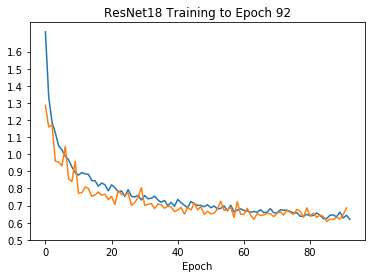

In [96]:

plt.plot(ResNet18_Train_losses)
plt.plot(ResNet18_val_losses)
plt.title('ResNet18 Training to Epoch 92')
plt.xlabel('Epoch')
plt.yticks(np.arange(0.5, 1.7, 0.1))
plt.ylabel('')
plt.show()

###### Visualisazion ResNet50 --> Epoch 128

Zweiter versuch mit dem ResNet 50
- Batch 3 
- Worker 2

TODO: Link für Video ResNet50

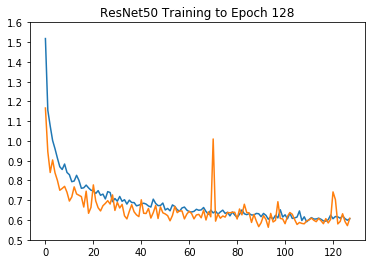

In [95]:
ResNet50_Train_losses = pickle.load(
    open('/content/drive/My Drive/U_Net_Datasets/training_logs/model_50_b3_w2/epoch_losses_train.pkl','rb'))
ResNet50_val_losses = pickle.load(
    open('/content/drive/My Drive/U_Net_Datasets/training_logs/model_50_b3_w2/epoch_losses_val.pkl','rb'))

ResNet18_Train_losses = pickle.load(
    open('/content/drive/My Drive/U_Net_Datasets/training_logs/model_5/epoch_losses_train.pkl','rb'))
ResNet18_val_losses = pickle.load(
    open('/content/drive/My Drive/U_Net_Datasets/training_logs/model_5/epoch_losses_val.pkl','rb'))

plt.plot(ResNet50_Train_losses )
plt.plot(ResNet50_val_losses)
plt.title('ResNet50 Training to Epoch 128')
plt.yticks(np.arange(0.5, 1.7, 0.1))
plt.ylabel('')
plt.show()


####Run on Seq

Erstellen eines Videos auf Testdaten aus Stuttgart um zu Präsentieren wie es aussieht.

In [0]:


batch_size = 2

network = DeepLabV3("eval_seq", project_dir=datasetPath).cuda()
#network.load_state_dict(torch.load(datasetPath+"/pretrained_models/model_13_2_2_2_epoch_580.pth"))
#network.load_state_dict(torch.load("/content/drive/My Drive/U_Net_Datasets/training_logs/model_5/checkpoints/model_5_epoch_92.pth"))
network.load_state_dict(
    torch.load("/content/drive/My Drive/U_Net_Datasets/training_logs/model_50_b3_w2/checkpoints/model_50_b3_w2_epoch_128.pth"))
for sequence in ["00", "01", "02"]:
    print (sequence)

    val_dataset = DatasetSeq(cityscapes_data_path, cityscapes_meta_path, sequence=sequence)

    num_val_batches = int(len(val_dataset)/batch_size)
    print ("num_val_batches:", num_val_batches)

    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=1)

    network.eval() # (set in evaluation mode, this affects BatchNorm and dropout)
    unsorted_img_ids = []
    for step, (imgs, img_ids) in enumerate(val_loader):
        with torch.no_grad(): # (corresponds to setting volatile=True in all variables, this is done during inference to reduce memory consumption)
            imgs = Variable(imgs).cuda() # (shape: (batch_size, 3, img_h, img_w))

            outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))

            ####################################################################
            # save data for visualization:
            ####################################################################
            outputs = outputs.data.cpu().numpy() # (shape: (batch_size, num_classes, img_h, img_w))
            pred_label_imgs = np.argmax(outputs, axis=1) # (shape: (batch_size, img_h, img_w))
            pred_label_imgs = pred_label_imgs.astype(np.uint8)

            for i in range(pred_label_imgs.shape[0]):
                pred_label_img = pred_label_imgs[i] # (shape: (img_h, img_w))
                img_id = img_ids[i]
                img = imgs[i] # (shape: (3, img_h, img_w))

                img = img.data.cpu().numpy()
                img = np.transpose(img, (1, 2, 0)) # (shape: (img_h, img_w, 3))
                img = img*np.array([0.229, 0.224, 0.225])
                img = img + np.array([0.485, 0.456, 0.406])
                img = img*255.0
                img = img.astype(np.uint8)

                pred_label_img_color = label_img_to_color(pred_label_img)
                overlayed_img = 0.35*img + 0.65*pred_label_img_color
                overlayed_img = overlayed_img.astype(np.uint8)

                img_h = overlayed_img.shape[0]
                img_w = overlayed_img.shape[1]

                cv2.imwrite(network.model_dir + "/" + img_id + ".png", img)
                cv2.imwrite(network.model_dir + "/" + img_id + "_pred.png", pred_label_img_color)
                cv2.imwrite(network.model_dir + "/" + img_id + "_overlayed.png", overlayed_img)

                unsorted_img_ids.append(img_id)

    ############################################################################
    # create visualization video:
    ############################################################################
    out = cv2.VideoWriter("%s/stuttgart_%s_combined.avi" % (network.model_dir, sequence), cv2.VideoWriter_fourcc(*"MJPG"), 20, (2*img_w, 2*img_h))
    sorted_img_ids = sorted(unsorted_img_ids)
    for img_id in sorted_img_ids:
        img = cv2.imread(network.model_dir + "/" + img_id + ".png", -1)
        pred_img = cv2.imread(network.model_dir + "/" + img_id + "_pred.png", -1)
        overlayed_img = cv2.imread(network.model_dir + "/" + img_id + "_overlayed.png", -1)

        combined_img = np.zeros((2*img_h, 2*img_w, 3), dtype=np.uint8)

        combined_img[0:img_h, 0:img_w] = img
        combined_img[0:img_h, img_w:(2*img_w)] = pred_img
        combined_img[img_h:(2*img_h), (int(img_w/2)):(img_w + int(img_w/2))] = overlayed_img

        out.write(combined_img)

    out.release()

pretrained resnet, 18
pretrained resnet, 50
00
num_val_batches: 299


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
